## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train_old import load_model
from text import text_to_sequence, code_to_sequence
from denoiser import Denoiser
from utils import load_code_dict, load_filepaths_and_text

/data/sls/u/wnhsu/code/tacotron2_factory/tacotron2_20191017_dev/plotting_utils.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/data/sls/u/wnhsu/vtenvs/pt1.3_cp36/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/data/sls/u/wnhsu/vtenvs/pt1.3_cp36/lib/python3.6/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/data/sls/u/wnhsu/vtenvs/pt1.3_cp36/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 563

In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [3]:
# hparams = create_hparams()
hparams = create_hparams(
    ("text_or_code=code,code_dict=./filelists/rdvq_01000_01100/code_dict_quant3"
     ",code_key=code_quant3,n_symbols=1025,collapse_code=True"))
hparams.sampling_rate = 22050

Parsing command line hparams: --text_or_code=code,--code_dict=./filelists/rdvq_01000_01100/code_dict_quant3,--code_key=code_quant3,--n_symbols=1025,--collapse_code=True


#### Load model from checkpoint

In [4]:
# checkpoint_path = "./pretrained/tacotron2_statedict.pt"
# checkpoint_path = "./exps/basic_ljs_run1/checkpoint_77000"
# checkpoint_path = "./exps/finished/code_mdl-01000-01100_vq3_ljs_run1/checkpoint_77000"
# checkpoint_path = "./exps/finished/code_mdl-01000-01100_vq3_ljs_run1/checkpoint_5000"
# checkpoint_path = "./exps/finished/code_mdl-01000-01100_vq3_chunk_ljs_run1/checkpoint_5000"
checkpoint_path = "./exps/finished/code_mdl-01000-01100_vq3_chunk_ljs_run1/checkpoint_77000"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [5]:
waveglow_path = './pretrained/waveglow_256channels_new.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

#### Prepare text input

In [6]:
# text = "Waveglow is really awesome!"
# text = "How is the weather today? I'm thinking about going for a walk."
# sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
# sequence = torch.autograd.Variable(
#     torch.from_numpy(sequence)).cuda().long()


# data = load_filepaths_and_text("filelists/rdvq_01000_01100/ljs_audio_text_test_filelist.txt")
data = load_filepaths_and_text("filelists/rdvq_01000_01100/places_eng_400k_train_filelist.txt")
code_dict = load_code_dict(hparams.code_dict)
idx = 4
code = data[idx][hparams.code_key].split()
print('(TEXT LEN=%d) %s' % (len(data[idx]['text']), data[idx]['text']))
print('(CODE LEN=%d) %s' % (len(code), ' '.join(code)))
sequence = np.array(code_to_sequence(code, code_dict, True))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()
ipd.display(ipd.Audio(data[idx]['audio']))

(TEXT LEN=86) photograph of a train that is blurry going down railroad tracks on a very overcast day
(CODE LEN=174) 263 5 5 5 5 461 192 863 304 993 663 663 663 791 663 445 445 746 110 110 451 451 297 59 494 501 501 254 254 254 501 374 374 717 803 803 803 362 362 256 256 128 846 289 417 870 870 985 703 556 242 911 847 847 329 582 501 110 852 852 852 494 909 913 181 336 224 224 224 582 230 820 820 84 84 910 256 775 962 775 560 502 706 489 689 689 993 128 160 847 89 249 249 427 129 537 537 58 453 453 87 12 445 110 860 860 245 87 84 84 454 48 48 417 570 870 985 703 556 552 807 0 535 27 289 606 59 791 993 1003 852 89 89 176 190 723 84 820 910 560 560 224 44 44 44 815 87 554 663 417 821 112 765 141 536 564 451 451 913 880 216 216 983 427 564 362 362 560 846 5 5 208 32 32


#### Decode text input and plot results

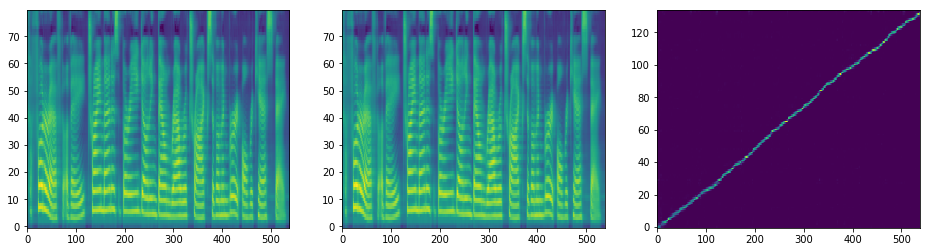

In [7]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

#### Synthesize audio from spectrogram using WaveGlow

In [8]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

#### (Optional) Remove WaveGlow bias

In [9]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 